In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pwd

'/content'

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# This is in my google drive
train_dataset_directory = '/content/drive/MyDrive/Dataset/train/train'
test_dataset_directory = '/content/drive/MyDrive/Dataset/test/test'

training_dataset = image_dataset_from_directory(train_dataset_directory,                                         
                                             batch_size=32,
                                             image_size=(224, 224),
                                             seed = 42,
                                             subset= 'training',
                                             validation_split=0.2) # 20% of data will be used for validation)                        https://stackoverflow.com/questions/58565394/what-is-the-difference-between-sparse-categorical-crossentropy-and-categorical-c

validation_datset = image_dataset_from_directory(train_dataset_directory,
                                              validation_split=0.2, # 20% of data will be used for validation
                                              subset='validation',
                                              seed=42, # random number shuffler of data. Same as training for consistency
                                              image_size=(224, 224),
                                              batch_size=32)

test_dataset = image_dataset_from_directory(test_dataset_directory,                                         
                                             batch_size=32,
                                             image_size=(224, 224)) 



class_names = training_dataset.class_names
print(class_names)

Found 993 files belonging to 3 classes.
Using 795 files for training.
Found 993 files belonging to 3 classes.
Using 198 files for validation.
Found 267 files belonging to 3 classes.
['paper', 'plastic', 'trash']


In [ ]:
from tensorflow.data.experimental import AUTOTUNE

# Allows the system to automatiucally determine optimal buffer size. May help improve traininng speed
training_dataset = training_dataset.prefetch(buffer_size=AUTOTUNE) 

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras import Sequential
# data augeentation here. https://www.tensorflow.org/tutorials/images/data_augmentation#data_augmentation_2

# Data augmentation layers. This does NOT increase the amount of data. Instead it augements on the Fly
# Meaning during training the model will randomly see the data rotated, flipped, zoomed or translated
data_augmentation = Sequential([
    RandomRotation(0.1),
    RandomFlip("horizontal"),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1),
])


train_ds = training_dataset.map(lambda images, labels: (data_augmentation(images), labels))
print(train_ds)

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
# pre process input 
from tensorflow.keras.applications.vgg16 import preprocess_input

# pre-processes by the mean and standard deviation of certain values, while making the pixels be between [-1,1] See here https://pytorch.org/hub/pytorch_vision_mobilenet_v2/
train_ds = training_dataset.map(lambda images, labels: (preprocess_input(images), labels))
val_ds = validation_datset.map(lambda images, labels: (preprocess_input(images), labels))
test_dataset = test_dataset.map(lambda images, labels: (preprocess_input(images), labels))

In [ ]:
from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.models import Model
from keras import regularizers
from keras.layers import Dense, Flatten, Dropout, BatchNormalization

base_model = VGG16(weights = "imagenet", include_top=False, 
                         input_shape = (224,224, 3))
base_model.trainable = None
last_layer = base_model.get_layer('block5_pool') ## Save last layer of network
last_output = last_layer.output


flattened_output = Flatten()(last_output)

hidden_layer = Dense(64, activation='relu', name='FC_3')(flattened_output)
batch_norm = BatchNormalization()(hidden_layer)
dropout = Dropout(0.5)(batch_norm)
output_layer = Dense(3, activation='softmax', name='softmax')(dropout)

new_model = Model(inputs=base_model.input, outputs = output_layer)
new_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# Standard params. Adam and sparse loss are community defaults
from keras.optimizers.adam import Adam

# default learning rate is 0.001. Lowering it to improve training data
adam = Adam(learning_rate = 0.0001) 
new_model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = new_model.fit(
    train_ds,
    epochs=19,
    validation_data=val_ds,
    verbose = 2,
    batch_size = len(train_ds)) # uses BGD instead of SGD

Epoch 1/19
25/25 - 9s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.1953 - val_accuracy: 0.9293 - 9s/epoch - 363ms/step
Epoch 2/19
25/25 - 5s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.1930 - val_accuracy: 0.9293 - 5s/epoch - 208ms/step
Epoch 3/19
25/25 - 7s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.1951 - val_accuracy: 0.9293 - 7s/epoch - 265ms/step
Epoch 4/19
25/25 - 6s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.1940 - val_accuracy: 0.9293 - 6s/epoch - 220ms/step
Epoch 5/19
25/25 - 6s - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.1949 - val_accuracy: 0.9293 - 6s/epoch - 226ms/step
Epoch 6/19
25/25 - 6s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.1990 - val_accuracy: 0.9293 - 6s/epoch - 253ms/step
Epoch 7/19
25/25 - 6s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.1929 - val_accuracy: 0.9242 - 6s/epoch - 254ms/step
Epoch 8/19
25/25 - 6s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2029 - val_accuracy: 0.9242 - 6s/epoch - 220ms/step
Epoch 9/19
25/25 - 5s - 

In [ ]:
test_loss, test_accuracy = new_model.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


9/9 [==============================] - 2s 123ms/step - loss: 0.2565 - accuracy: 0.9251
Test accuracy: 92.51%


In [ ]:
new_model.save('/content/drive/MyDrive/vgg16.h5')
# previous save saved somewhere i dont know

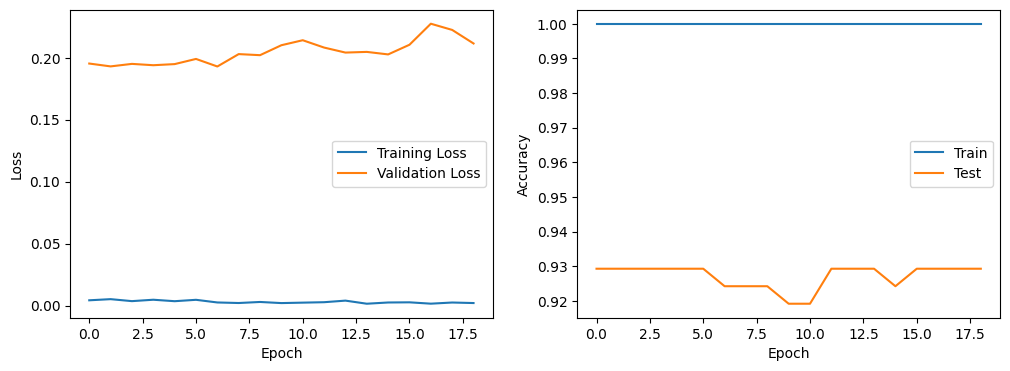

'\nGraph one shows that the model is learning, mbut failed to generalize on the validation.\nThis is a form of overfitting the data. Our model is too complex for our data.\n\nSolutions: Obtain more data to avoid overfitting or perform overfitting techniques\n'

In [ ]:
import matplotlib.pyplot as plt

# Plot the training/validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training/validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

"""
Graph one shows that the model is learning, mbut failed to generalize on the validation.
This is a form of overfitting the data. Our model is too complex for our data.

Solutions: Obtain more data to avoid overfitting or perform overfitting techniques
"""

In [ ]:
import tensorflow as tf

# Changes the large regualr file into a tensorflow lite file
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()

# https://medium.com/axinc-ai/convert-keras-models-to-tensorflow-lite-e654994fb93c
with open('/content/drive/MyDrive/vgg16.tflite', 'wb') as f:
    f.write(tflite_model)